# Mineria en Diario Jornada

###  Desarrollar un crawler para el sitio web del Diario Jornada, que almacene la información de las secciones más relevantes de la página en una base de datos (puede usar Python + BeautifulSoup). Con la información recabada, resolver y graficar las siguientes operaciones.

### 1. Desarrolar un Scraper (realizado con Scrapy)

In [2]:
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.item import Field
from scrapy.item import Item
from scrapy.spiders import CrawlSpider, Rule
from scrapy.selector import Selector
from scrapy.loader.processors import MapCompose
from scrapy.linkextractors import LinkExtractor
from scrapy.loader import ItemLoader
import json
import logging

In [2]:
class JsonWriterPipeline(object):

    def open_spider(self, spider):
        self.file = open('resultados.jl', 'w')

    def close_spider(self, spider):
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

In [3]:
class Articulo(Item):
    fecha = Field()
    seccion = Field()
    titulo = Field()
    visitas = Field()
    texto = Field()

In [4]:
class Jornada(CrawlSpider):
    items = []
    name = "Scraper-Jornada"
    custom_settings = {
        'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36',
        'CLOSESPIDER_PAGECOUNT': 200,
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, # Used for pipeline 1
        'FEED_FORMAT':'json',                                 # Used for pipeline 2
        'FEED_URI': 'jornada.json'                        # Used for pipeline 2
    }

    download_delay = 5

    allowed_domains = ["www.diariojornada.com.ar"]

    start_urls = [
        "https://www.diariojornada.com.ar/provincia/",
        "https://www.diariojornada.com.ar/policiales/",
        "https://www.diariojornada.com.ar/economia/",
        "https://www.diariojornada.com.ar/sociedad/",
        "https://www.diariojornada.com.ar/paismundo/"
    ]

    rules = (
        # Detalles de los articulos
        Rule(
            LinkExtractor(
                allow=r'/283[5-8]\d+'
            ), follow=True, callback='parse_items'
        ),
    )

    def parse_items(self, response):
        sel = Selector(response)
        item = ItemLoader(Articulo(), sel)
        
        item.add_xpath(
            'fecha', '//span[@id="ContentPlaceHolder1_lbl_Fecha"]/text()')
        item.add_xpath(
            'seccion',
            '//div[@class="well-body"]/h3/a/text()')

        item.add_xpath('titulo',
                       '//div[@class="well-body"]/h1/span[@id="ContentPlaceHolder1_lbl_Titulo"]/text()')

        item.add_xpath('visitas', '//div[@class="p-05"]/span/text()')
        item.add_xpath('texto', '//div[@id="cuerpo"]/p/text()')

        yield item.load_item()


In [5]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'
})

process.crawl(Jornada)
process.start()

2020-09-25 12:00:31 [scrapy.utils.log] INFO: Scrapy 2.3.0 started (bot: scrapybot)
2020-09-25 12:00:31 [scrapy.utils.log] INFO: Versions: lxml 4.5.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.6.9 (default, Jul 17 2020, 12:50:27) - [GCC 8.4.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1g  21 Apr 2020), cryptography 2.1.4, Platform Linux-5.4.0-48-generic-x86_64-with-Ubuntu-18.04-bionic
2020-09-25 12:00:31 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2020-09-25 12:00:31 [scrapy.crawler] INFO: Overridden settings:
{'CLOSESPIDER_PAGECOUNT': 200,
 'LOG_LEVEL': 30,
 'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
               '(KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'}
2020-09-25 12:00:31 [py.warnings] WARNING: /home/lucila/.local/lib/python3.6/site-packages/scrapy/extensions/feedexport.py:239: ScrapyDeprecationWarning: The `FEED_URI` and `FEED_FORMAT` settings have been dep

Se obtuvo un archivo json con los 200 articulos scrapeados llamado 'jornada.json', que se puede encontrar en este directorio.  

### 2.  Mostrar cuáles son las 5 noticias más relevantes según cantidad de visitas a nivel global .

In [123]:
# 5 noticias mas releventes a nivel global 
with open('jornada.json') as file:
    data = json.load(file)
    
articulos_globales = []
for articulo in data:
    articulos_globales.append({"titulo":articulo['titulo'], "visitas":articulo['visitas'], "fecha":articulo['fecha'], "seccion":articulo['seccion']})
    
articulos_globales.sort(key=lambda ag: int(ag['visitas']), reverse=True)

for ag in range(5):
    print("Titulo: {0}. Fecha: {2}. \nSeccion: {3}. Visitas: {1}.\n".format(articulos_globales[ag]['titulo'], articulos_globales[ag]['visitas'], articulos_globales[ag]['fecha'], articulos_globales[ag]['seccion']))

Titulo: Renunció el diputado que besó los senos de su mujer en plena sesión virtual. Fecha: 24/09/2020 18:56. 
Seccion: PAÍS & MUNDO. Visitas: 6387.

Titulo: Trelew: se sacó la tobillera y se escapó . Fecha: 24/09/2020 02:00. 
Seccion: POLICIALES. Visitas: 6244.

Titulo: Madryn: se accidentó haciendo motocross y murió. Fecha: 24/09/2020 19:56. 
Seccion: POLICIALES. Visitas: 5957.

Titulo: “La heladera está vacía”. Fecha: 23/09/2020 02:00. 
Seccion: PROVINCIA. Visitas: 5946.

Titulo: Insólito: vecinos hicieron retirar de una rotonda estatuas de peces porque parecen "penes". Fecha: 21/09/2020 21:08. 
Seccion: SOCIEDAD. Visitas: 5445.



### 3. Mostrar cuáles son las 5 noticias más relevantes según cantidad de visitas por sección.

In [120]:
# 5 noticias mas releventes de seccion Provincia
with open('jornada.json') as file:
    data = json.load(file)

    
#seccion Provincia
articulos_provincia = []
seccion_provincia = "PROVINCIA"
for art in articulos_globales:
    if art['seccion'] == seccion_provincia:
        articulos_provincia.append(art)

articulos_provincia.sort(key=lambda ap: int(ap['visitas']), reverse=True)

print("Sección PROVINCIA\n")
for ag in range(5):
    print("Titulo: {0}. Fecha: {2}. \nVisitas: {1}.\n".format(articulos_provincia[ag]['titulo'], articulos_provincia[ag]['visitas'], articulos_provincia[ag]['fecha']))

Sección PROVINCIA

Titulo: “La heladera está vacía”. Fecha: 23/09/2020 02:00. 
Visitas: 5946.

Titulo: Hubo otros 200 casos y tres nuevos fallecidos por Covid-19 en Chubut. Fecha: 23/09/2020 23:00. 
Visitas: 4275.

Titulo: Chubut comienza a negociar un salvataje de Nación: uno por uno, el equipo de funcionarios que viajó a Buenos Aires. Fecha: 23/09/2020 02:00. 
Visitas: 3856.

Titulo: Hubo otro récord de casos en un día (247) y cuatro nuevos fallecidos en Chubut por Covid-19. Fecha: 22/09/2020 23:26. 
Visitas: 3646.

Titulo: En Chubut hubo 115 nuevos casos de Covid-19 y otros tres fallecidos. Fecha: 21/09/2020 23:21. 
Visitas: 3572.



In [126]:
# 5 noticias mas releventes de seccion Policiales
with open('jornada.json') as file:
    data = json.load(file)

#seccion Policiales
articulos_policiales = []
seccion_policiales = "POLICIALES"
for art in articulos_globales:
    if art['seccion'] == seccion_policiales:
        articulos_policiales.append(art)

articulos_policiales.sort(key=lambda ap: int(ap['visitas']), reverse=True)

print("Sección POLICIALES\n")
for ag in range(5):
    print("Titulo: {0}. Fecha: {2}. \nVisitas: {1}.\n".format(articulos_policiales[ag]['titulo'], articulos_policiales[ag]['visitas'], articulos_policiales[ag]['fecha']))

Sección POLICIALES

Titulo: Trelew: se sacó la tobillera y se escapó . Fecha: 24/09/2020 02:00. 
Visitas: 6244.

Titulo: Madryn: se accidentó haciendo motocross y murió. Fecha: 24/09/2020 19:56. 
Visitas: 5957.

Titulo: Incendio en Trelew: murieron dos perros y un hombre perdió todo. Fecha: 22/09/2020 09:26. 
Visitas: 4969.

Titulo: Detectaron un micro con 22 permisos truchos en el ingreso Norte a Trelew. Fecha: 24/09/2020 12:22. 
Visitas: 3116.

Titulo: Trelew: triple choque dejó a un conductor hospitalizado. Fecha: 24/09/2020 02:00. 
Visitas: 2766.



In [125]:
# 5 noticias mas releventes de seccion Economia
with open('jornada.json') as file:
    data = json.load(file)

#seccion Economia
articulos_economia = []
seccion_economia = "ECONOM\u00cdA"
for art in articulos_globales:
    if art['seccion'] == seccion_economia:
        articulos_economia.append(art)

articulos_economia.sort(key=lambda ap: int(ap['visitas']), reverse=True)

print("Sección ECONOMIA\n")
for ag in range(5):
    print("Titulo: {0}. Fecha: {2}. \nVisitas: {1}.\n".format(articulos_economia[ag]['titulo'], articulos_economia[ag]['visitas'], articulos_economia[ag]['fecha']))

Sección ECONOMIA

Titulo: El Presidente anunció líneas de financiamiento y pidió cuidar los dólares para la producción. Fecha: 22/09/2020 10:28. 
Visitas: 606.

Titulo: El Producto Bruto Interno retrocedió 19,1% en el segundo trimestre del año. Fecha: 22/09/2020 16:15. 
Visitas: 394.

Titulo: El Ministerio de Agricultura confía en otra cosecha récord de maíz. Fecha: 23/09/2020 10:58. 
Visitas: 391.

Titulo: La pandemia provoca fuerte caída de ingresos a los trabajadores del mundo. Fecha: 23/09/2020 12:09. 
Visitas: 390.

Titulo: El Producto Bruto Interno retrocedió 19,1% en el segundo trimestre del año. Fecha: 22/09/2020 16:15. 
Visitas: 385.



In [124]:
# 5 noticias mas releventes de seccion Sociedad
with open('jornada.json') as file:
    data = json.load(file)

# seccion Sociedad
articulos_sociedad = []
seccion_sociedad = "SOCIEDAD"
for art in articulos_globales:
    if art['seccion'] == seccion_sociedad:
        articulos_sociedad.append(art)

articulos_sociedad.sort(key=lambda ap: int(ap['visitas']), reverse=True)

print("Sección SOCIEDAD\n")
for ag in range(5):
    print("Titulo: {0}. Fecha: {2}. \nVisitas: {1}.\n".format(
        articulos_sociedad[ag]['titulo'], articulos_sociedad[ag]['visitas'], articulos_sociedad[ag]['fecha']))


Sección SOCIEDAD

Titulo: Insólito: vecinos hicieron retirar de una rotonda estatuas de peces porque parecen "penes". Fecha: 21/09/2020 21:08. 
Visitas: 5445.

Titulo: Viral: aprovechó su cumpleaños y "deschavó" al novio y su mejor amiga, que la engañaban. Fecha: 24/09/2020 21:25. 
Visitas: 4858.

Titulo: Video impresionante: escalaban un iceberg y se les dio vuelta en medio del mar. Fecha: 21/09/2020 19:41. 
Visitas: 2719.

Titulo: Los defensores de los imputados de “La Manada”  denuncian que el fiscal Rivarola “armó la causa”. Fecha: 25/09/2020 02:00. 
Visitas: 1019.

Titulo: Un referente de entidad que niega la pandemia estafó a una obra social. Fecha: 23/09/2020 14:09. 
Visitas: 647.



In [123]:
# 5 noticias mas releventes de seccion Pais & Mundo
with open('jornada.json') as file:
    data = json.load(file)

# seccion Pais & Mundo
articulos_paismundo = []
seccion_paismundo = "PA\u00cdS & MUNDO"
for art in articulos_globales:
    if art['seccion'] == seccion_paismundo:
        articulos_paismundo.append(art)

articulos_paismundo.sort(key=lambda ap: int(ap['visitas']), reverse=True)

print("Sección PAIS & MUNDO\n")
for ag in range(5):
    print("Titulo: {0}. Fecha: {2}. \nVisitas: {1}.\n".format(
        articulos_paismundo[ag]['titulo'], articulos_paismundo[ag]['visitas'], articulos_paismundo[ag]['fecha']))


Sección PAIS & MUNDO

Titulo: Renunció el diputado que besó los senos de su mujer en plena sesión virtual. Fecha: 24/09/2020 18:56. 
Visitas: 6387.

Titulo: Argentina tiene "nuevo mapa" y Tierra del Fuego pasó a ser el centro del país. Fecha: 22/09/2020 19:58. 
Visitas: 3888.

Titulo: La CGT quiere organizar una marcha el 17 de octubre en apoyo a Alberto Fernández. Fecha: 21/09/2020 19:09. 
Visitas: 516.

Titulo:  “Es grave e inmoral”, dijo Rossi en Cadena Tiempo sobre el espionaje ilegal a familiares del ARA San Juan. Fecha: 24/09/2020 19:35. 
Visitas: 497.

Titulo: El Gobierno aprueba el pago del ATP6 con salarios de septiembre. Fecha: 23/09/2020 15:58. 
Visitas: 488.



### 3. Mostrar cómo están distribuidas las palabras de cierto artículo.

In [112]:
# Elegir la primer noticia del json

with open('jornada.json') as file:
    data = json.load(file)

articulo = data[0]
texto_articulo = articulo['texto']

In [113]:
# Obtener las palabras del articulo separadas 

texto = ""
for oracion in texto_articulo:
    texto += oracion

palabras = texto.split()
lista_palabras = []
for palabra in palabras:
    lista_palabras.append(palabra.strip('‘’:;,.').lower())

In [114]:
# Contar la cantidad de veces que aparecen las palabras separadas anteriormente
frecuenciaPalab = []
for w in lista_palabras:
    frecuenciaPalab.append(lista_palabras.count(w))

In [115]:
# Lista de palabras vacias

#Español
palabrasvac = ['él', 'ésta', 'éstas', 'éste', 'éstos']
palabrasvac += ['última', 'últimas', 'último', 'últimos']
palabrasvac += ['a', 'añadió', 'aún', 'actualmente', 'adelante']
palabrasvac += ['además', 'afirmó', 'agregó', 'ahí', 'ahora', 'al']
palabrasvac += ['algún', 'algo', 'alguna', 'algunas', 'alguno', 'algunos']
palabrasvac += ['alrededor', 'ambos', 'ante', 'anterior', 'antes',]
palabrasvac += ['apenas', 'aproximadamente', 'aquí', 'así']
palabrasvac += ['aseguró', 'aunque', 'ayer', 'bajo', 'bien', 'buen']
palabrasvac += ['buena', 'buenas', 'bueno', 'buenos', 'cómo', 'cada']
palabrasvac += ['casi', 'cerca', 'cierto', 'cinco', 'comentó', 'como']
palabrasvac += ['con', 'conocer', 'consideró', 'considera', 'contra']
palabrasvac += ['cosas', 'creo', 'cual', 'cuales', 'cualquier', 'cuando']
palabrasvac += ['cuanto', 'cuatro', 'cuenta', 'da', 'dado', 'dan', 'dar']
palabrasvac += ['de', 'debe', 'deben', 'debido', 'decir', 'dejó', 'del']
palabrasvac += ['demás', 'dentro', 'desde', 'después', 'dice', 'dicen']
palabrasvac += ['dicho', 'dieron', 'diferente', 'diferentes', 'dijeron']
palabrasvac += ['dijo', 'dio', 'donde', 'dos', 'durante', 'e', 'ejemplo']
palabrasvac += ['el', 'ella', 'ellas', 'ello', 'ellos', 'embargo', 'en']
palabrasvac += ['encuentra', 'entonces', 'entre', 'era', 'eran', 'es']
palabrasvac += ['esa', 'esas', 'ese', 'eso', 'esos', 'está', 'están', 'esta', 'ése', 'ésa']
palabrasvac += ['estaba', 'estaban', 'estamos', 'estar', 'estará', 'estas']
palabrasvac += ['este', 'esto', 'estos', 'estoy', 'estuvo', 'ex', 'existe']
palabrasvac += ['existen', 'explicó', 'expresó', 'fin', 'fue', 'fuera']
palabrasvac += ['fueron', 'gran', 'grandes', 'ha', 'había', 'habían']
palabrasvac += ['haber', 'habrá', 'hace', 'hacen', 'hacer', 'hacerlo']
palabrasvac += ['hacia', 'haciendo', 'han', 'hasta', 'hay', 'haya']
palabrasvac += ['he', 'hecho', 'hemos', 'hicieron', 'hizo', 'hoy']
palabrasvac += ['hubo', 'igual', 'incluso', 'indicó', 'informó']
palabrasvac += ['junto', 'la', 'lado', 'las', 'le', 'les', 'llegó']
palabrasvac += ['lleva', 'llevar', 'lo', 'los', 'luego', 'lugar']
palabrasvac += ['más', 'manera', 'manifestó', 'mayor', 'me', 'mediante']
palabrasvac += ['mejor', 'mencionó', 'menos', 'mi', 'mientras', 'misma']
palabrasvac += ['mismas', 'mismo', 'mismos', 'momento', 'mucha', 'muchas']
palabrasvac += ['mucho', 'muchos', 'muy', 'nada', 'nadie', 'ni', 'ningún']
palabrasvac += ['ninguna', 'ningunas', 'ninguno', 'ningunos', 'no', 'nos']
palabrasvac += ['nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro']
palabrasvac += ['nuestros', 'nueva', 'nuevas', 'nuevo', 'nuevos', 'nunca']
palabrasvac += ['o', 'ocho', 'otra', 'otras', 'otro', 'otros', 'para']
palabrasvac += ['parece', 'parte', 'partir', 'pasada', 'pasado', 'pero']
palabrasvac += ['pesar', 'poca', 'pocas', 'poco', 'pocos', 'podemos']
palabrasvac += ['podrá', 'podrán', 'podría', 'podrían', 'poner', 'por']
palabrasvac += ['porque', 'posible', 'próximo', 'próximos', 'primer']
palabrasvac += ['primera', 'primero', 'primeros', 'principalmente', 'propia']
palabrasvac += ['propias', 'propio', 'propios', 'pudo', 'pueda']
palabrasvac += ['puede', 'pueden', 'pues', 'qué', 'que', 'quedó']
palabrasvac += ['queremos', 'quién', 'quien', 'quienes', 'quiere']
palabrasvac += ['realizó', 'realizado', 'realizar', 'respecto', 'sí']
palabrasvac += ['sólo', 'se', 'señaló', 'sea', 'sean', 'según', 'segunda']
palabrasvac += ['segundo', 'seis', 'ser', 'será', 'serán', 'sería', 'si']
palabrasvac += ['sido', 'siempre', 'siendo', 'siete', 'sigue', 'siguiente']
palabrasvac += ['sin', 'sino', 'sobre', 'sola', 'solamente', 'solas', 'solo']
palabrasvac += ['solos', 'son', 'su', 'sus', 'tal', 'también', 'tampoco']
palabrasvac += ['tan', 'tanto', 'tenía', 'tendrá', 'tendrán', 'tenemos']
palabrasvac += ['tener', 'tenga', 'tengo', 'tenido', 'tercera', 'tiene']
palabrasvac += ['tienen', 'toda', 'todas', 'todavía', 'todo', 'todos']
palabrasvac += ['total', 'tras', 'trata', 'través', 'tres', 'tuvo']
palabrasvac += ['un', 'una', 'unas', 'uno', 'unos', 'usted', 'va']
palabrasvac += ['vamos', 'van', 'varias', 'varios', 'veces', 'ver']
palabrasvac += ['vez', 'y', 'ya', 'yo']

#Ingles
palabrasvac += ['a', 'about', 'above', 'across', 'after', 'afterwards']
palabrasvac += ['again', 'against', 'all', 'almost', 'alone', 'along']
palabrasvac += ['already', 'also', 'although', 'always', 'am', 'among']
palabrasvac += ['amongst', 'amoungst', 'amount', 'an', 'and', 'another']
palabrasvac += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']
palabrasvac += ['are', 'around', 'as', 'at', 'back', 'be', 'became']
palabrasvac += ['because', 'become', 'becomes', 'becoming', 'been']
palabrasvac += ['before', 'beforehand', 'behind', 'being', 'below']
palabrasvac += ['beside', 'besides', 'between', 'beyond', 'bill', 'both']
palabrasvac += ['bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant']
palabrasvac += ['co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de']
palabrasvac += ['describe', 'detail', 'did', 'do', 'done', 'down', 'due']
palabrasvac += ['during', 'each', 'eg', 'eight', 'either', 'eleven', 'else']
palabrasvac += ['elsewhere', 'empty', 'enough', 'etc', 'even', 'ever']
palabrasvac += ['every', 'everyone', 'everything', 'everywhere', 'except']
palabrasvac += ['few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first']
palabrasvac += ['five', 'for', 'former', 'formerly', 'forty', 'found']
palabrasvac += ['four', 'from', 'front', 'full', 'further', 'get', 'give']
palabrasvac += ['go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her']
palabrasvac += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
palabrasvac += ['herself', 'him', 'himself', 'his', 'how', 'however']
palabrasvac += ['hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed']
palabrasvac += ['interest', 'into', 'is', 'it', 'its', 'itself', 'keep']
palabrasvac += ['last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made']
palabrasvac += ['many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine']
palabrasvac += ['more', 'moreover', 'most', 'mostly', 'move', 'much']
palabrasvac += ['must', 'my', 'myself', 'name', 'namely', 'neither', 'never']
palabrasvac += ['nevertheless', 'next', 'nine', 'no', 'nobody', 'none']
palabrasvac += ['noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of']
palabrasvac += ['off', 'often', 'on','once', 'one', 'only', 'onto', 'or']
palabrasvac += ['other', 'others', 'otherwise', 'our', 'ours', 'ourselves']
palabrasvac += ['out', 'over', 'own', 'part', 'per', 'perhaps', 'please']
palabrasvac += ['put', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed']
palabrasvac += ['seeming', 'seems', 'serious', 'several', 'she', 'should']
palabrasvac += ['show', 'side', 'since', 'sincere', 'six', 'sixty', 'so']
palabrasvac += ['some', 'somehow', 'someone', 'something', 'sometime']
palabrasvac += ['sometimes', 'somewhere', 'still', 'such', 'system', 'take']
palabrasvac += ['ten', 'than', 'that', 'the', 'their', 'them', 'themselves']
palabrasvac += ['then', 'thence', 'there', 'thereafter', 'thereby']
palabrasvac += ['therefore', 'therein', 'thereupon', 'these', 'they']
palabrasvac += ['thick', 'thin', 'third', 'this', 'those', 'though', 'three']
palabrasvac += ['three', 'through', 'throughout', 'thru', 'thus', 'to']
palabrasvac += ['together', 'too', 'top', 'toward', 'towards', 'twelve']
palabrasvac += ['twenty', 'two', 'un', 'under', 'until', 'up', 'upon']
palabrasvac += ['us', 'very', 'via', 'was', 'we', 'well', 'were', 'what']
palabrasvac += ['whatever', 'when', 'whence', 'whenever', 'where']
palabrasvac += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon']
palabrasvac += ['wherever', 'whether', 'which', 'while', 'whither', 'who']
palabrasvac += ['whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with']
palabrasvac += ['within', 'without', 'would', 'yet', 'you', 'your']
palabrasvac += ['yours', 'yourself', 'yourselves']

In [116]:
# Dada una lista de palabras, retira cualquiera que esté
# en la lista de palabras vacias.

def quitarPalabrasvac(listaPalabras, palabrasvac):
    return [w for w in listaPalabras if w not in palabrasvac]

In [117]:
# Dada una lista de palabras, devuelve un diccionario de
# pares de palabra-frecuencia.

def listaPalabrasDicFrec(listaPalabras):
    frecuenciaPalab = [listaPalabras.count(p) for p in listaPalabras]
    return dict(list(zip(listaPalabras,frecuenciaPalab)))

In [118]:
# Obtengo un diccionario con la frecuencia de cada palabra

lista_sin_pv = quitarPalabrasvac(lista_palabras, palabrasvac)
diccionario = listaPalabrasDicFrec(lista_sin_pv)

In [121]:
# Creo un dataframe a partir del diccionario anterior
import pandas as pd

df = pd.DataFrame([[key, diccionario[key]] for key in diccionario.keys()], columns=['Palabra', 'Frecuencia'])
df.to_csv('distribucion.csv')
df

,Palabra,Frecuencia
0,jornada,1
1,manifestaciones,1
2,vivió,1
3,rawson,1
4,protagonizada,1
...,...,...
205,sostuvo,1
206,principal,2
207,cobrar,2
208,salarios,2


Distribucion de Palabras


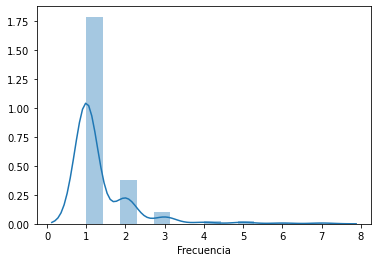

In [120]:
# Mostrar distribucion de palabras del texto del articulo a partir del DataFrame
import seaborn as sns

cols = ['Palabra','Frecuencia']

df = df[cols].dropna()

sns.distplot(df['Frecuencia'])
print("Distribucion de Palabras")

### 4. Mostrar el número promedio, máximo y mínimo de palabras, sentencias, párrafos de un conjunto de noticias de su preferencia.

In [154]:
# Dado un texto, separa sus palabras y
# devuelve la cantidad de palabras.

def contar_palabras(texto_articulo):
    text = ""
    for oracion in texto_articulo:
        text += oracion

    palabras = text.split()
    lista_palabras = []
    for palabra in palabras:
        lista_palabras.append(palabra.strip('‘’:;,.').lower())
    
    text= ""
    return len(lista_palabras)

# Dado un texto,
# devuelve la cantidad de oraciones.

def contar_oraciones(texto):
    return len(texto)

In [155]:
# Se eligio las noticias de la seccion Policiales

with open('jornada.json') as file:
    data = json.load(file)
    
articulos_globales = []
for articulo in data:
    articulos_globales.append({"titulo":articulo['titulo'], "texto":articulo['texto'], "seccion":articulo['seccion']})

#seccion Policiales
articulos_policiales = []
seccion_policiales = "POLICIALES"
for art in articulos_globales:
    if art['seccion'] == seccion_policiales:
        articulos_policiales.append(art)    

textos = []
cant_palabras = 0
cant_oraciones = 0
for articulo in articulos_policiales:
    cant_palabras = contar_palabras(articulo['texto'])
    cant_oraciones = contar_oraciones(articulo['texto'])
    textos.append({'titulo': articulo['titulo'], 'cant_palabras': cant_palabras, 'cant_oraciones': cant_oraciones})

In [161]:
import numpy as np 

t_palabras = []
t_oraciones = []
for t in textos:
    t_palabras.append(t['cant_palabras'])
    t_oraciones.append(t['cant_oraciones'])

minima_cant_palabras = min(t_palabras) 
maxima_cant_palabras = max(t_palabras)    
promedio_palabras = np.mean(t_palabras)  

minima_cant_oraciones = min(t_oraciones) 
maxima_cant_oraciones = max(t_oraciones)    
promedio_oraciones = np.mean(t_oraciones)   

print("PALABRAS")
print("Promedio:{0:.2f} \n Cantidad Minima: {1}. Cantidad Maxima: {2}".format(promedio_palabras,minima_cant_palabras,maxima_cant_palabras))
print("\n")
print("ORACIONES")
print("Promedio:{0:.2f} \n Cantidad Minima: {1}. Cantidad Maxima: {2}".format(promedio_oraciones,minima_cant_oraciones,maxima_cant_oraciones))

PALABRAS
Promedio:328.39 
 Cantidad Minima: 69. Cantidad Maxima: 892


ORACIONES
Promedio:7.39 
 Cantidad Minima: 2. Cantidad Maxima: 19
